In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer

In [16]:
df = pd.read_csv('data/phone_temp_dataset.csv')
df.sample(5)

,ambient_temp,cpu_usage,gpu_usage,ram_usage,screen_brightness,battery_level,charging,case_on,fan,num_bg_apps,time_since_boot,network_type,app_type,app_intensity,phone_temp,overheat
13109,25.060710,34.751516,16.838341,14.474699,61.058356,45.001272,0,0,0,2,38.516191,4g,social,0.3,45.287756,0
6610,33.408717,8.822831,13.912023,57.165258,69.068215,77.566155,0,1,0,2,49.913678,4g,video,0.6,61.742511,1
15150,32.951352,16.431158,13.576556,20.681877,17.198162,85.254521,0,1,0,2,360.520960,wifi,video,0.6,60.855854,1
18602,27.649774,5.117337,16.901976,30.049341,29.562586,93.763419,0,1,0,4,92.243494,wifi,social,0.3,47.960081,0
9126,32.854728,26.140569,0.000000,7.771987,10.937424,30.397422,0,0,0,3,95.414727,wifi,idle,0.1,48.156157,0


In [17]:
num_features = ['ambient_temp','cpu_usage','gpu_usage','ram_usage','screen_brightness','battery_level','num_bg_apps','time_since_boot','app_intensity']
cat_features = ['charging','case_on','fan','network_type','app_type']  # charging/case_on/fan are binary but treat as cat for pipeline
target_reg = 'phone_temp'
target_clf = 'overheat'

In [18]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ambient_temp,20000.0,30.026275,5.003830,10.387999,26.668616,30.038503,33.409534,45.000000
cpu_usage,20000.0,28.505067,16.605580,0.000000,15.800361,26.650694,39.349426,92.197577
gpu_usage,20000.0,25.044219,16.157467,0.000000,12.892890,23.415387,35.245215,100.000000
ram_usage,20000.0,33.354103,18.619333,0.000000,19.088441,31.533078,45.866201,100.000000
screen_brightness,20000.0,54.740674,26.913785,0.000000,32.525592,54.876500,77.564387,100.000000
battery_level,20000.0,71.354165,25.911090,0.000000,59.115702,79.378965,91.450174,99.999066
charging,20000.0,0.196900,0.397666,0.000000,0.000000,0.000000,0.000000,1.000000
case_on,20000.0,0.595600,0.490788,0.000000,0.000000,1.000000,1.000000,1.000000
fan,20000.0,0.048300,0.214405,0.000000,0.000000,0.000000,0.000000,1.000000
num_bg_apps,20000.0,2.009650,1.415753,0.000000,1.000000,2.000000,3.000000,10.000000


In [19]:
df['overheat'].value_counts()
df['overheat'].value_counts(normalize=True)

overheat
1    0.8443
0    0.1557
Name: proportion, dtype: float64

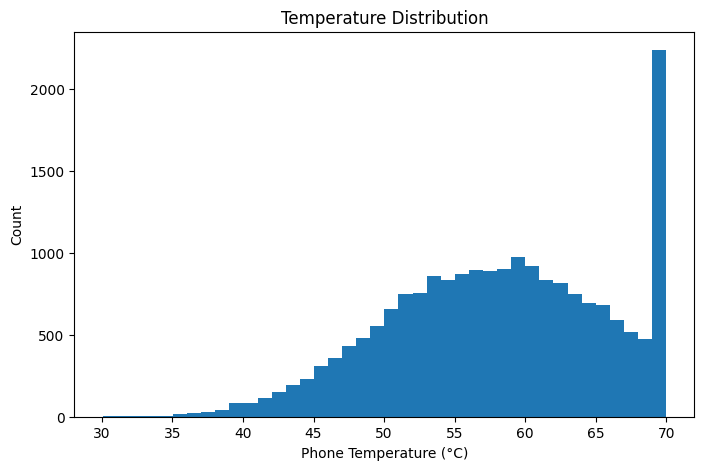

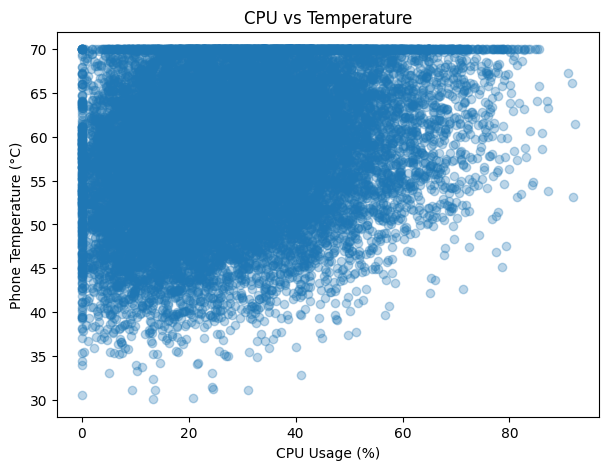

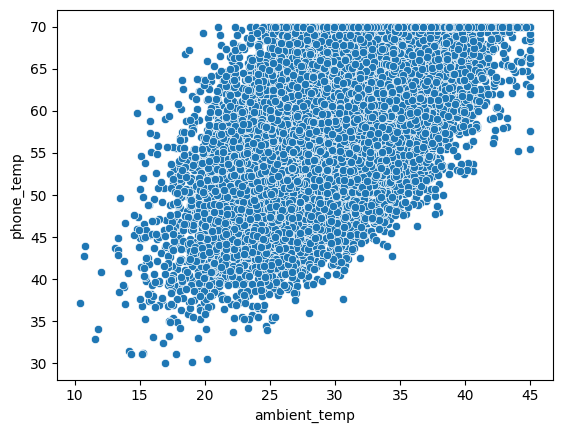

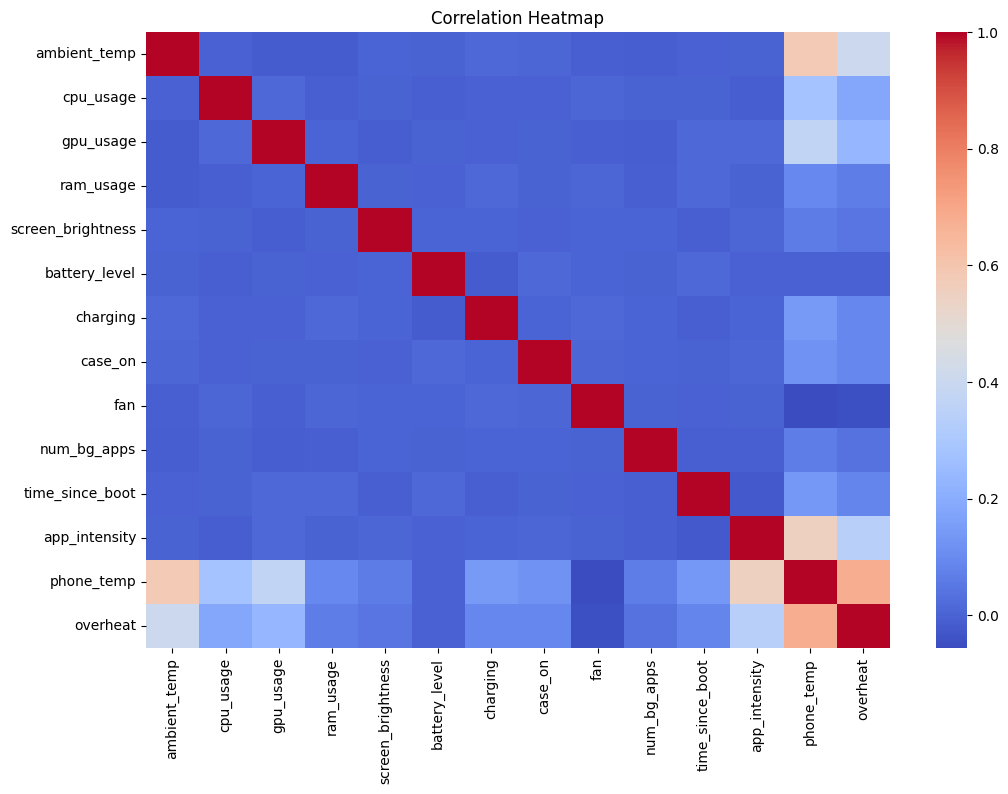

In [20]:
plt.figure(figsize=(8,5))
plt.hist(df['phone_temp'], bins=40)
plt.xlabel("Phone Temperature (°C)")
plt.ylabel("Count")
plt.title("Temperature Distribution")
plt.show()



plt.figure(figsize=(7,5))
plt.scatter(df['cpu_usage'], df['phone_temp'], alpha=0.3)
plt.xlabel("CPU Usage (%)")
plt.ylabel("Phone Temperature (°C)")
plt.title("CPU vs Temperature")
plt.show()


sns.scatterplot(x='ambient_temp', y='phone_temp', data=df)


plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

In [21]:
df['cpu_gpu_mean'] = (df['cpu_usage'] + df['gpu_usage']) / 2
df['high_load'] = ((df['cpu_usage'] > 70) | (df['gpu_usage'] > 70)).astype(int)
df['hot_ambient'] = (df['ambient_temp'] > 35).astype(int)
df['boot_log'] = np.log1p(df['time_since_boot'])
df['cpu_case_interaction'] = df['cpu_usage'] * df['case_on']
df = pd.get_dummies(df, columns=['network_type', 'app_type'], drop_first=True)

In [22]:
from sklearn.preprocessing import StandardScaler
numeric_columns = [
    'ambient_temp',
    'cpu_usage',
    'gpu_usage',
    'ram_usage',
    'screen_brightness',
    'battery_level',
    'num_bg_apps',
    'time_since_boot',
    'app_intensity',
    'cpu_gpu_mean',
    'high_load',
    'hot_ambient',
    'boot_log',
    'cpu_case_interaction',
    'phone_temp'   # only for regression, not classifier
]

scaler = StandardScaler()
scaled = scaler.fit_transform(df[numeric_columns])

In [23]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['phone_temp','overheat'])
y_reg = df['phone_temp']       # regression target
y_clf = df['overheat']         # classification target

X_train, X_test, y_train_reg, y_test_reg = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

X_train_c, X_test_c, y_train_clf, y_test_clf = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)


In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

reg = LinearRegression()
reg.fit(X_train, y_train_reg)

y_pred_reg = reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))
r2 = r2_score(y_test_reg, y_pred_reg)

print("RMSE =", rmse)
print("R2 Score =", r2)


RMSE = 1.8890925046342064
R2 Score = 0.9411369086421422


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_c)
X_test_scaled = scaler.transform(X_test_c)

clf = LogisticRegression(
    solver="saga",
    max_iter=5000,
    class_weight="balanced"
)

clf.fit(X_train_scaled, y_train_clf)
y_pred_c = clf.predict(X_test_scaled)


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_c, y_train_clf)

rf_pred = rf.predict(X_test_c)
rf_prob = rf.predict_proba(X_test_c)[:,1]


In [27]:
print("Accuracy :", accuracy_score(y_test_clf, rf_pred))
print("Precision:", precision_score(y_test_clf, rf_pred))
print("Recall   :", recall_score(y_test_clf, rf_pred))
print("F1 Score :", f1_score(y_test_clf, rf_pred))
print("AUC      :", roc_auc_score(y_test_clf, rf_prob))


Accuracy : 0.94325
Precision: 0.9505148741418764
Recall   : 0.9840094758661534
F1 Score : 0.9669722100974829
AUC      : 0.9829297994031003


In [28]:
import pandas as pd
import numpy as np

feature_names = X_train_c.columns
importances = rf.feature_importances_

fi = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi.head(15)


,feature,importance
0,ambient_temp,0.277858
12,cpu_gpu_mean,0.120860
11,app_intensity,0.113167
2,gpu_usage,0.074918
20,app_type_idle,0.047270
1,cpu_usage,0.044999
19,app_type_game,0.038611
14,hot_ambient,0.035559
3,ram_usage,0.032626
15,boot_log,0.031245


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


X = df.drop(columns=['phone_temp', 'overheat'])
y = df['phone_temp']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_reg = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train)


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsample

In [30]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np



y_pred = rf_reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("MAE :", mae)
print("R2  :", r2)

RMSE: 2.060701672264566
MAE : 1.609201124299912
R2  : 0.9299566573043928


In [31]:
# 1. Predict temperature using regression model
temp_pred = rf_reg.predict(X_test)

# 2. Predict overheat probability using classification model
overheat_prob = rf.predict_proba(X_test_c)[:, 1]

# 3. Custom thresholds (domain based)
TEMP_THRESHOLD = 50      # °C
PROB_THRESHOLD = 0.4     # safer threshold

# 4. Final alert decision
final_alert = []
for t, p in zip(temp_pred, overheat_prob):
    if t >= TEMP_THRESHOLD or p >= PROB_THRESHOLD:
        final_alert.append(1)   # OVERHEATING
    else:
        final_alert.append(0)   # SAFE

# 5. Create result dataframe
results = X_test.copy()
results['Actual_Temp'] = y_test.values
results['Predicted_Temp'] = temp_pred
results['Overheat_Prob'] = overheat_prob
results['Final_Alert'] = final_alert

# 6. Advice generation logic
def give_advice(row):
    if row['gpu_usage'] > 80:
        return "Close heavy gaming or graphics apps"
    elif row['cpu_usage'] > 75:
        return "Close background apps"
    elif row['charging'] == 1:
        return "Unplug charger to reduce heat"
    elif row['case_on'] == 1:
        return "Remove phone case temporarily"
    else:
        return "Reduce screen brightness or rest phone"

results['Advice'] = results.apply(give_advice, axis=1)

# 7. Evaluate final alert system
from sklearn.metrics import classification_report

print("FINAL ALERT SYSTEM PERFORMANCE:\n")
print(classification_report(y_test_clf, results['Final_Alert']))

# 8. Show sample output
print("\nSAMPLE OUTPUT:\n")
results[['Actual_Temp','Predicted_Temp','Overheat_Prob','Final_Alert','Advice']].head()


FINAL ALERT SYSTEM PERFORMANCE:

              precision    recall  f1-score   support

           0       0.99      0.11      0.20       623
           1       0.86      1.00      0.92      3377

    accuracy                           0.86      4000
   macro avg       0.92      0.56      0.56      4000
weighted avg       0.88      0.86      0.81      4000


SAMPLE OUTPUT:



,Actual_Temp,Predicted_Temp,Overheat_Prob,Final_Alert,Advice
10650,66.026535,62.985853,0.990000,1,Remove phone case temporarily
2041,51.971831,52.065442,0.996667,1,Reduce screen brightness or rest phone
8668,52.238476,51.784859,0.993333,1,Remove phone case temporarily
1114,48.543837,52.330642,0.943333,1,Remove phone case temporarily
13902,57.920122,58.804060,0.936667,1,Reduce screen brightness or rest phone


In [ ]:
import joblib
import pandas as pd
import numpy as np

joblib.dump(rf, "overheat_classifier.pkl")
joblib.dump(rf_reg, "temperature_regressor.pkl")

print("Models saved successfully as .pkl files")

Models saved successfully as .pkl files


In [39]:
feature_columns = X_train.columns.tolist()
joblib.dump(feature_columns, "model_features.pkl")


['model_features.pkl']

In [40]:
import joblib
import pandas as pd
import numpy as np

# LOAD MODELS & FEATURE LIST
reg_loaded = joblib.load("temperature_regressor.pkl")
clf_loaded = joblib.load("overheat_classifier.pkl")
feature_columns = joblib.load("model_features.pkl")

# RAW NEW INPUT (human readable)
raw_input = {
    'ambient_temp': 36,
    'cpu_usage': 85,
    'gpu_usage': 78,
    'ram_usage': 70,
    'screen_brightness': 90,
    'battery_level': 45,
    'charging': 1,
    'case_on': 1,
    'fan': 0,
    'num_bg_apps': 6,
    'time_since_boot': 180,
    'app_intensity': 1.0,
    'app_type': 'game',        # RAW
    'network_type': '5g'       # RAW
}

# Convert to DataFrame
raw_df = pd.DataFrame([raw_input])

# One-hot encode (same as training)
raw_df = pd.get_dummies(raw_df)

# Reindex to EXACT training features
raw_df = raw_df.reindex(columns=feature_columns, fill_value=0)

# Derived features (same logic as training)
raw_df['cpu_gpu_mean'] = (raw_input['cpu_usage'] + raw_input['gpu_usage']) / 2
raw_df['high_load'] = int(raw_input['cpu_usage'] > 70)
raw_df['hot_ambient'] = int(raw_input['ambient_temp'] > 35)
raw_df['boot_log'] = np.log1p(raw_input['time_since_boot'])
raw_df['cpu_case_interaction'] = raw_input['cpu_usage'] * raw_input['case_on']

# PREDICTION
pred_temp = reg_loaded.predict(raw_df)[0]
overheat_prob = clf_loaded.predict_proba(raw_df)[0][1]

# FINAL DECISION
if pred_temp >= 50 or overheat_prob >= 0.4:
    alert = "OVERHEATING RISK"
else:
    alert = "SAFE"

print("Predicted Temperature:", round(pred_temp,2), "°C")
print("Overheat Probability :", round(overheat_prob,2))
print("Final Alert          :", alert)


Predicted Temperature: 70.0 °C
Overheat Probability : 1.0
Final Alert          : OVERHEATING RISK
